In [1]:
import math
import matplotlib.pyplot as plt
import torch
import viser.transforms as vst
from internal.models.gaussian_model_simplified import GaussianModelSimplified
from internal.utils.sh_utils import eval_sh as vanilla_eval_sh
from internal.utils.sh_utils import C0, C1, C2, C3, C4

# Define the function to calculate the result from each degree

In [2]:
def eval_sh_for_each_degree(deg, sh, dirs):
    result_list = []

    assert deg <= 4 and deg >= 0
    coeff = (deg + 1) ** 2
    assert sh.shape[-1] >= coeff

    result = C0 * sh[..., 0]
    result_list.append(result)
    if deg > 0:
        x, y, z = dirs[..., 0:1], dirs[..., 1:2], dirs[..., 2:3]
        result_list.append(-
                           C1 * y * sh[..., 1] +
                           C1 * z * sh[..., 2] -
                           C1 * x * sh[..., 3])

        if deg > 1:
            xx, yy, zz = x * x, y * y, z * z
            xy, yz, xz = x * y, y * z, x * z
            result_list.append(+
                               C2[0] * xy * sh[..., 4] +
                               C2[1] * yz * sh[..., 5] +
                               C2[2] * (2.0 * zz - xx - yy) * sh[..., 6] +
                               C2[3] * xz * sh[..., 7] +
                               C2[4] * (xx - yy) * sh[..., 8])

            if deg > 2:
                result_list.append(+
                                   C3[0] * y * (3 * xx - yy) * sh[..., 9] +
                                   C3[1] * xy * z * sh[..., 10] +
                                   C3[2] * y * (4 * zz - xx - yy) * sh[..., 11] +
                                   C3[3] * z * (2 * zz - 3 * xx - 3 * yy) * sh[..., 12] +
                                   C3[4] * x * (4 * zz - xx - yy) * sh[..., 13] +
                                   C3[5] * z * (xx - yy) * sh[..., 14] +
                                   C3[6] * x * (xx - 3 * yy) * sh[..., 15])

                if deg > 3:
                    result_list.append(+ C4[0] * xy * (xx - yy) * sh[..., 16] +
                                       C4[1] * yz * (3 * xx - yy) * sh[..., 17] +
                                       C4[2] * xy * (7 * zz - 1) * sh[..., 18] +
                                       C4[3] * yz * (7 * zz - 3) * sh[..., 19] +
                                       C4[4] * (zz * (35 * zz - 30) + 3) * sh[..., 20] +
                                       C4[5] * xz * (7 * zz - 3) * sh[..., 21] +
                                       C4[6] * (xx - yy) * (7 * zz - 1) * sh[..., 22] +
                                       C4[7] * xz * (xx - 3 * yy) * sh[..., 23] +
                                       C4[8] * (xx * (xx - 3 * yy) - yy * (3 * xx - yy)) * sh[..., 24])
    return result_list

# Load trained model

In [3]:
ckpt = torch.load("../outputs/lego/gsplat-0509/checkpoints/epoch=300-step=30000.ckpt")
model = GaussianModelSimplified.construct_from_state_dict(ckpt["state_dict"], 3, torch.device("cuda"))
features = model.get_features
features.shape

'features_extra' not found in state_dict, create an empty one


torch.Size([243616, 16, 3])

In [4]:
# build a rotation matrix for test
so3 = vst.SO3.from_rpy_radians(math.pi / 2, math.pi / 2, 0.)
rotation_matrix = torch.tensor(so3.as_matrix(), dtype=torch.float, device="cuda")
rotation_matrix

tensor([[ 0.0000e+00,  1.0000e+00,  1.1102e-16],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+00],
        [-1.0000e+00,  1.1102e-16, -2.2204e-16]], device='cuda:0')

In [5]:
# pick a camera center
camera_center = torch.max(model.get_xyz, dim=0).values * 3
camera_center  # treat as rotated

tensor([1.9264, 3.4611, 3.0735], device='cuda:0')

In [6]:
xyz = model.get_xyz[:8]  # treat as rotated
features = model.get_features[:8]
shs_view = features.transpose(1, 2)
xyz.shape, features.shape, shs_view.shape

(torch.Size([8, 3]), torch.Size([8, 16, 3]), torch.Size([8, 3, 16]))

In [7]:
dir_pp = (xyz - camera_center)
dir_pp_normalized = dir_pp / dir_pp.norm(dim=1, keepdim=True)
dir_pp_normalized_rotated = dir_pp_normalized @ rotation_matrix

# Validate eval_sh_for_each_degree

In [8]:
rgb_each_degree = eval_sh_for_each_degree(3, shs_view, dir_pp_normalized)
rgb_acc = torch.sum(torch.stack(rgb_each_degree), dim=0)
rgb_from_vanilla_eval_sh = vanilla_eval_sh(3, shs_view, dir_pp_normalized)
torch.allclose(rgb_acc, rgb_from_vanilla_eval_sh)

True

# Reference: calculate use rotated view direction

In [9]:
reference_sh_result = eval_sh_for_each_degree(3, shs_view, dir_pp_normalized_rotated)
reference_sh_result[1]

tensor([[ 0.0845,  0.0530, -0.0050],
        [ 0.0042,  0.0239, -0.0011],
        [ 0.0148,  0.0213,  0.0169],
        [-0.0117,  0.0010,  0.0099],
        [-0.0222, -0.0228, -0.0026],
        [-0.0306, -0.0089,  0.0182],
        [-0.0568,  0.0115,  0.0452],
        [-0.0021, -0.0048, -0.0233]], device='cuda:0')

# Then calculate use rotated SHs, result is expected to be the same as above output
Only the 1st extra degree currently

## 1. Validate that matrix calculation formula is correct
$$
\begin{bmatrix}
r'\\
g'\\
b'
\end{bmatrix}
_{\mathrm{degree=1}}
=
C_{1}
\begin{bmatrix}
sh_{r1} & sh_{r2} & sh_{r3} \\
sh_{g1} & sh_{g2} & sh_{g3} \\
sh_{b1} & sh_{b2} & sh_{b3} \\
\end{bmatrix}
\begin{bmatrix}
-1 & & \\
& 1 & \\
& & -1
\end{bmatrix}
\begin{bmatrix}
y \\
z \\
x
\end{bmatrix}
=
C_{1}
\begin{bmatrix}
-ysh_{r1}+zsh_{r2}-xsh_{r3} \\
... \\
...
\end{bmatrix}
=
C_{1}\mathbf{S}^{'}\mathbf{v}^{'}
$$

$\mathbf{S}^{'}$ is the result of the SH matrix $\mathbf{S}$ multiply with sign matrix. $\mathbf{v}^{'}$ is the view direction in `yzx` order.

In [10]:
# pick degree=1
shs_view[0], shs_view[0, :, 1:4]

(tensor([[-4.4785e-01,  1.7727e-01,  2.4680e-02, -1.2806e-01,  1.5333e-01,
           8.1059e-03,  2.7878e-02,  2.7736e-02, -2.0938e-01,  5.9768e-02,
          -8.0829e-02, -2.7069e-01, -3.3752e-02,  5.8807e-02,  7.0073e-02,
          -3.8681e-02],
         [-7.3134e-01,  1.4808e-01,  1.4852e-02, -5.8777e-02,  1.5323e-01,
           1.2031e-02,  4.5827e-02, -3.5026e-02, -1.1840e-01,  3.4073e-02,
          -7.5348e-03, -2.2315e-01, -6.3368e-02,  6.7628e-02, -1.7063e-05,
           4.7210e-02],
         [-7.4237e-01,  1.0384e-01, -5.0373e-02,  3.1059e-02,  3.4267e-02,
          -9.9935e-03,  6.5961e-02, -7.0922e-02,  4.3605e-02,  1.0505e-02,
           1.1347e-01, -1.0186e-01, -4.5713e-02,  4.1600e-02, -3.6869e-02,
           1.7137e-01]], device='cuda:0'),
 tensor([[ 0.1773,  0.0247, -0.1281],
         [ 0.1481,  0.0149, -0.0588],
         [ 0.1038, -0.0504,  0.0311]], device='cuda:0'))

In [11]:
# compare vanilla calculation and matrix calculation
vanilla_calculate_result = reference_sh_result[1][0]
vanilla_calculate_result

tensor([ 0.0845,  0.0530, -0.0050], device='cuda:0')

In [12]:
first_gs_sh = shs_view[0, :, 1:4]
first_gs_view_dir_rotated = dir_pp_normalized_rotated[0]
first_gs_view_dir_rotated

tensor([ 0.6747, -0.4025,  0.6186], device='cuda:0')

In [13]:
# calculate by matrix mode
sign_matrix = torch.tensor([
    [-1, 0, 0],
    [0, 1, 0],
    [0, 0, -1],
], device=first_gs_sh.device, dtype=torch.float)
matrix_calculate_result = C1 * first_gs_view_dir_rotated[[1, 2, 0]] @ (first_gs_sh @ sign_matrix).T
matrix_calculate_result, torch.allclose(matrix_calculate_result, vanilla_calculate_result)  # should be true

(tensor([ 0.0845,  0.0530, -0.0050], device='cuda:0'), True)

## 2. Use original view direction, rotated SHs
$
\mathbf{rgb}_{\mathrm{degree=1}}=C_{1}\mathbf{S}^{'}\mathbf{R}^{''}\mathbf{v}^{'}
$

$\mathbf{R}^{''}$ is obtained by inversing the rotation matrix $\mathbf{R}$ that rotating the scene, and move the 1st row and column to the 3rd.

In [14]:
# pick first original view direction
first_gs_view_dir = dir_pp_normalized[0]
first_gs_view_dir

tensor([-0.4025, -0.6186, -0.6747], device='cuda:0')

In [15]:
# reorder rotation matrix, move first row to last
rotation_matrix_reorder = rotation_matrix[[1, 2, 0], :][:, [1, 2, 0]]
rotation_matrix, rotation_matrix_reorder

(tensor([[ 0.0000e+00,  1.0000e+00,  1.1102e-16],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00],
         [-1.0000e+00,  1.1102e-16, -2.2204e-16]], device='cuda:0'),
 tensor([[ 0.0000e+00, -1.0000e+00,  0.0000e+00],
         [ 1.1102e-16, -2.2204e-16, -1.0000e+00],
         [ 1.0000e+00,  1.1102e-16,  0.0000e+00]], device='cuda:0'))

In [16]:
rotation_matrix_inverse_reorder = rotation_matrix.T[[1, 2, 0], :][:, [1, 2, 0]]
rotation_matrix_inverse_reorder

tensor([[ 0.0000e+00,  1.1102e-16,  1.0000e+00],
        [-1.0000e+00, -2.2204e-16,  1.1102e-16],
        [ 0.0000e+00, -1.0000e+00,  0.0000e+00]], device='cuda:0')

In [17]:
# test reorder
transformed_vire_dir = (first_gs_view_dir @ rotation_matrix)
transformed_vire_dir_reorder = transformed_vire_dir[[1, 2, 0]]
(f"before_reorder="
 f"{transformed_vire_dir.cpu().numpy()}, "
 f"after_reorder="
 f"{transformed_vire_dir_reorder.cpu().numpy()}")

'before_reorder=[ 0.67471176 -0.40254462  0.61864513], after_reorder=[-0.40254462  0.61864513  0.67471176]'

In [18]:
# the result should be the same as `after_reorder`
first_gs_view_dir_reorder = first_gs_view_dir[[1, 2, 0]]
print(f"first_gs_view_dir_reorder={first_gs_view_dir_reorder}")
first_gs_view_dir_reorder @ rotation_matrix_reorder

first_gs_view_dir_reorder=tensor([-0.6186, -0.6747, -0.4025], device='cuda:0')


tensor([-0.4025,  0.6186,  0.6747], device='cuda:0')

In [19]:
# calculate by matrix formula
result_from_rotated_sh = C1 * first_gs_view_dir[[1, 2, 0]] @ (
        first_gs_sh @ sign_matrix @ rotation_matrix_inverse_reorder).T
result_from_rotated_sh, torch.allclose(result_from_rotated_sh, vanilla_calculate_result)

(tensor([ 0.0845,  0.0530, -0.0050], device='cuda:0'), True)

# 3. Remove sign matrix
Target: first_gs_sh @ SOME_MATRIX @ sign_matrix == first_gs_sh @ sign_matrix @ rotation_matrix_inverse_reorder

In [20]:
expected_rotated_sh_result = first_gs_sh @ sign_matrix @ rotation_matrix_inverse_reorder
expected_rotated_sh_result

tensor([[-0.0247, -0.1281, -0.1773],
        [-0.0149, -0.0588, -0.1481],
        [ 0.0504,  0.0311, -0.1038]], device='cuda:0')

In [21]:
torch.allclose((first_gs_sh @ sign_matrix @ rotation_matrix_inverse_reorder @ sign_matrix) @ sign_matrix,
               expected_rotated_sh_result)

True

# Batch mode

In [22]:
# rotate shs
shs_view_rotated = shs_view.clone()
print(shs_view_rotated.shape)
shs_view_rotated[..., 1:4] = shs_view_rotated[..., 1:4] @ sign_matrix @ rotation_matrix_inverse_reorder @ sign_matrix

torch.Size([8, 3, 16])


In [23]:
torch.allclose(shs_view_rotated[0, :, 1:4] @ sign_matrix, expected_rotated_sh_result)

True

In [24]:
batch_eval_sh_for_each_degree_result = eval_sh_for_each_degree(1, shs_view_rotated, dir_pp_normalized)
torch.allclose(batch_eval_sh_for_each_degree_result[1][0], vanilla_calculate_result)

True

From: https://github.com/graphdeco-inria/gaussian-splatting/issues/176#issuecomment-2060513169

In [25]:
from e3nn import o3
import einops
from einops import einsum


def transform_shs(shs_feat, rot_rotation_matrix):
    #degree 1 transformation for now 
    frist_degree_shs = shs_feat[:, 0:1]
    # permuting the last rgb to brg
    mat = torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]]).to(device=shs_feat.device).float()

    rot_angles = o3._rotation.matrix_to_angles(rot_rotation_matrix)
    #Construction coefficient
    D_0 = o3.wigner_D(0, rot_angles[0], rot_angles[1], rot_angles[2])
    D_1 = o3.wigner_D(1, rot_angles[0], rot_angles[1], rot_angles[2])
    D_2 = o3.wigner_D(2, rot_angles[0], rot_angles[1], rot_angles[2])
    D_3 = o3.wigner_D(3, rot_angles[0], rot_angles[1], rot_angles[2])

    #rotation of the shs features
    two_degree_shs = shs_feat[:, 0:3]
    two_degree_shs = torch.matmul(two_degree_shs, mat)
    two_degree_shs = einops.rearrange(two_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    # two_degree_shs = torch.matmul(two_degree_shs, D_1)
    two_degree_shs = einsum(
        D_1,
        two_degree_shs,
        "... i j, ... j -> ... i",
    )
    two_degree_shs = einops.rearrange(two_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    two_degree_shs = torch.matmul(two_degree_shs, torch.inverse(mat))
    shs_feat[:, 0:3] = two_degree_shs

    three_degree_shs = shs_feat[:, 3:8]
    three_degree_shs = torch.matmul(three_degree_shs, mat)
    three_degree_shs = einops.rearrange(three_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    # three_degree_shs = torch.matmul(three_degree_shs, D_2)
    three_degree_shs = einsum(
        D_2,
        three_degree_shs,
        "... i j, ... j -> ... i",
    )
    three_degree_shs = einops.rearrange(three_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    three_degree_shs = torch.matmul(three_degree_shs, torch.inverse(mat))
    shs_feat[:, 3:8] = three_degree_shs

    four_degree_shs = shs_feat[:, 8:15]
    four_degree_shs = torch.matmul(four_degree_shs, mat)
    four_degree_shs = einops.rearrange(four_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    # four_degree_shs = torch.matmul(four_degree_shs, D_3)
    four_degree_shs = einsum(
        D_3,
        four_degree_shs,
        "... i j, ... j -> ... i",
    )
    four_degree_shs = einops.rearrange(four_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    four_degree_shs = torch.matmul(four_degree_shs, torch.inverse(mat))
    shs_feat[:, 8:15] = four_degree_shs

    return shs_feat

In [26]:
wigner_D_rotated_shs = transform_shs(model.get_features.clone().cpu(), rotation_matrix.cpu())
wigner_D_rotated_shs.shape

torch.Size([243616, 16, 3])

In [27]:
# compare
(wigner_D_rotated_shs[:1, 1:4, :].transpose(1, 2),
 shs_view_rotated[:1, :, 1:4],
 torch.isclose(wigner_D_rotated_shs[:1, 1:4, :].transpose(1, 2), shs_view_rotated[:1, :, 1:4].cpu()))

(tensor([[[-0.0247,  0.4479, -0.1533],
          [-0.0149,  0.7313, -0.1532],
          [ 0.0504,  0.7424, -0.0343]]]),
 tensor([[[ 0.0247, -0.1281,  0.1773],
          [ 0.0149, -0.0588,  0.1481],
          [-0.0504,  0.0311,  0.1038]]], device='cuda:0'),
 tensor([[[False, False, False],
          [False, False, False],
          [False, False, False]]]))

# Render images to visualize the results

In [28]:
from internal.utils.gaussian_utils import GaussianTransformUtils
from internal.renderers.gsplat_renderer import GSPlatRenderer
from internal.cameras.cameras import Cameras, CameraType
from torchmetrics.image.psnr import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio().to(model.get_xyz.device)

Build basic camera pose

In [29]:
width, height = 800, 800
camera_pose_in_c2w = torch.tensor([[1.0000e+00, 1.7135e-03, -1.4987e-03, -7.1466e-02],
                                   [2.2765e-03, -7.5270e-01, 6.5836e-01, -1.6745e+00],
                                   [1.5905e-16, -6.5837e-01, -7.5270e-01, 1.7021e+00],
                                   [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])
camera_pose_in_w2c = torch.linalg.inv(camera_pose_in_c2w)
camera = Cameras(
    R=camera_pose_in_w2c[:3, :3].unsqueeze(0),
    T=camera_pose_in_w2c[:3, 3].unsqueeze(0),
    fx=torch.tensor([800.]),
    fy=torch.tensor([800.]),
    cx=torch.tensor([width // 2]),
    cy=torch.tensor([height // 2]),
    width=torch.tensor([width], dtype=torch.int),
    height=torch.tensor([height], dtype=torch.int),
    appearance_id=torch.tensor([0], dtype=torch.int),
    normalized_appearance_id=torch.tensor([0.]),
    distortion_params=None,
    camera_type=torch.tensor([CameraType.PERSPECTIVE], dtype=torch.int),
)[0]

Render a reference view

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


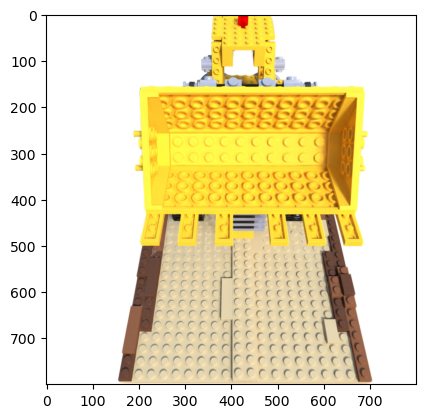

In [30]:
with torch.no_grad():
    reference_render_result = GSPlatRenderer.render(
        means3D=model.get_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=model.get_rotation,
        features=model.get_features,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device)
    )
plt.imshow((reference_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()

Rotate the scene

In [31]:
rotated_xyz = model.get_xyz @ torch.tensor(so3.as_matrix().T, device=model.get_xyz.device, dtype=torch.float)
rotated_rotations = torch.nn.functional.normalize(GaussianTransformUtils.quat_multiply(
    model.get_rotation, 
    torch.tensor(so3.as_quaternion_xyzw()[[3, 0, 1, 2]], device=rotated_xyz.device, dtype=torch.float),
))

Render the rotated scene

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


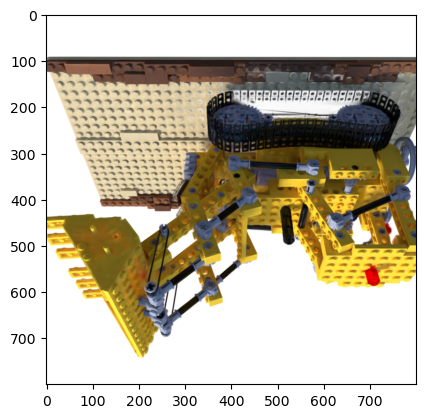

In [32]:
with torch.no_grad():
    rotated_render_result = GSPlatRenderer.render(
        means3D=rotated_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=rotated_rotations,
        features=model.get_features,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device)
    )
plt.imshow((rotated_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()

Rotate the camera to get the same view point in the rotated scene

In [33]:
rotated_camera_pose_in_c2w = camera_pose_in_c2w.clone()
rotated_camera_pose_in_c2w[:3, :3] = rotation_matrix.cpu() @ rotated_camera_pose_in_c2w[:3, :3]
rotated_camera_pose_in_c2w[:3, 3] = rotation_matrix.cpu() @ rotated_camera_pose_in_c2w[:3, 3]
rotated_camera_pose_in_w2c = torch.linalg.inv(rotated_camera_pose_in_c2w)
rotated_camera = Cameras(
    R=rotated_camera_pose_in_w2c[:3, :3].unsqueeze(0),
    T=rotated_camera_pose_in_w2c[:3, 3].unsqueeze(0),
    fx=torch.tensor([800.]),
    fy=torch.tensor([800.]),
    cx=torch.tensor([width // 2]),
    cy=torch.tensor([height // 2]),
    width=torch.tensor([width], dtype=torch.int),
    height=torch.tensor([height], dtype=torch.int),
    appearance_id=torch.tensor([0], dtype=torch.int),
    normalized_appearance_id=torch.tensor([0.]),
    distortion_params=None,
    camera_type=torch.tensor([CameraType.PERSPECTIVE], dtype=torch.int),
)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(35.0616, device='cuda:0')

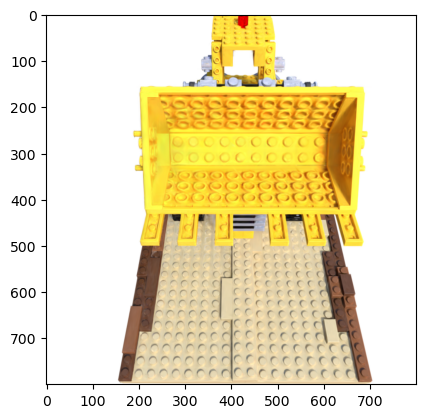

In [34]:
# render the rotated scene using the rotated camera
with torch.no_grad():
    rotated_camera_render_result = GSPlatRenderer.render(
        means3D=rotated_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=rotated_rotations,
        features=model.get_features,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=rotated_camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device)
    )
plt.imshow((rotated_camera_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()
psnr(rotated_camera_render_result["render"], reference_render_result["render"])

Render the rotated scene using the rotated camera, and rotated view directions

In [35]:
# from same view point, compare colors of the vanilla model to rotated one with rotated view directions
with torch.no_grad():
    # reference
    viewdirs_original = torch.nn.functional.normalize(model.get_xyz - camera.camera_center)  # (N, 3)
    rgbs_reference_each_degree = eval_sh_for_each_degree(model.active_sh_degree, model.get_features.transpose(1, 2), viewdirs_original)
    rgbs_reference = torch.stack(rgbs_reference_each_degree).sum(dim=0)
    
    # rotate view directions
    viewdirs_rotated = rotated_xyz - rotated_camera.camera_center
    # the rotated view direction should be close to the original directions
    viewdirs_rotated = torch.nn.functional.normalize(viewdirs_rotated @ rotation_matrix)
    rgbs_from_rotated_view_directions_each_degree = eval_sh_for_each_degree(model.active_sh_degree, model.get_features.transpose(1, 2), viewdirs_rotated)
    rgbs_from_rotated_view_directions = torch.stack(rgbs_from_rotated_view_directions_each_degree).sum(dim=0)

# they are expected to be identical
for i in range(len(rgbs_reference_each_degree)):
    print(f"is degree={i} all close: {torch.allclose(rgbs_reference_each_degree[i], rgbs_from_rotated_view_directions_each_degree[i])}")
(rgbs_reference - rgbs_from_rotated_view_directions).abs().mean()

is degree=0 all close: True
is degree=1 all close: True
is degree=2 all close: False
is degree=3 all close: False


tensor(7.0901e-09, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(102.7376, device='cuda:0')

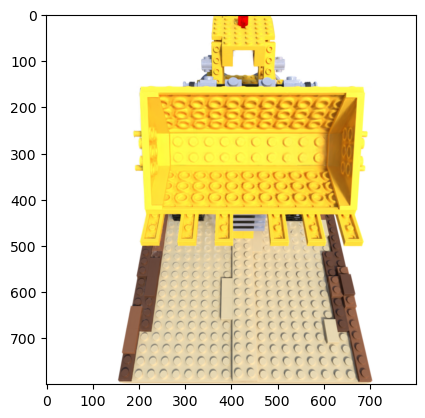

In [36]:
# the result is expected to be the same as the reference
with torch.no_grad():
    rotated_camera_with_rotated_view_direction_render_result = GSPlatRenderer.render(
        means3D=rotated_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=rotated_rotations,
        features=None,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=rotated_camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device),
        colors_precomp=(rgbs_from_rotated_view_directions + 0.5).clamp(min=0.),
    )
plt.imshow((rotated_camera_with_rotated_view_direction_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()
psnr(rotated_camera_with_rotated_view_direction_render_result["render"], reference_render_result["render"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(36.4079, device='cuda:0')

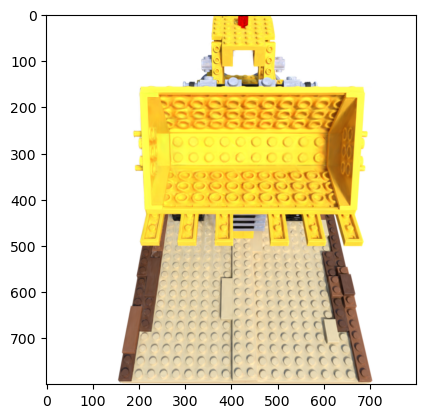

In [37]:
# render the rotated scene using the rotated camera, and the rotated 1st extra degree
with torch.no_grad():
    # rotate the 1st extra degree
    rotated_shs = model.get_features.clone()
    rotated_degree_1 = rotated_shs.transpose(1, 2)[..., 1:4] @ sign_matrix @ rotation_matrix_inverse_reorder @ sign_matrix
    rotated_shs[:, 1:4, :] = rotated_degree_1.transpose(1, 2)

    rotated_camera_with_rotated_1st_degree_render_result = GSPlatRenderer.render(
        means3D=rotated_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=rotated_rotations,
        features=rotated_shs,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=rotated_camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device)
    )
plt.imshow((rotated_camera_with_rotated_1st_degree_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()
psnr(rotated_camera_with_rotated_1st_degree_render_result["render"], reference_render_result["render"])

tensor(14.6178, device='cuda:0')

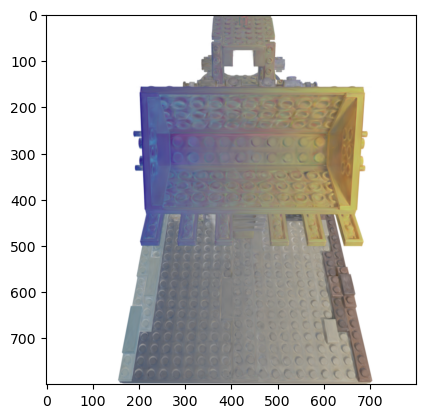

In [38]:
# render the rotated scene using the rotated camera and wigner_D_rotated_shs rotated SHs
with torch.no_grad():
    rotated_camera_with_D_rotated_shs_render_result = GSPlatRenderer.render(
        means3D=rotated_xyz,
        opacities=model.get_opacity,
        scales=model.get_scaling,
        rotations=rotated_rotations,
        features=wigner_D_rotated_shs.to(rotated_xyz.device),
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=rotated_camera.to_device(model.get_xyz.device),
        bg_color=torch.tensor([1., 1., 1.], device=model.get_xyz.device)
    )
plt.imshow((rotated_camera_with_D_rotated_shs_render_result["render"].permute(1, 2, 0)).cpu().numpy())
plt.draw()
psnr(rotated_camera_with_D_rotated_shs_render_result["render"], reference_render_result["render"])